In [ ]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import yaml
import matplotlib
import h5py
import matplotlib.lines
import matplotlib.ticker as mticker
import glob
import matplotlib.patches

import sys

sys.path.append("../lib/")
import matplotlib.pyplot as plt
from figparams import *

plt.rcParams.update(rc_params)
from utils import *


In [2]:
def corn(
    result,
    color,
    label=None,
    true=None,
    fig=None,
    alpha=1,
    line_s="-",
    line_s_corr="-",
    ht="step",
    linewidth=2,
    linewidth_corr=2,
    ctrue="k",
    pad=0.5,
):
    # Identify fixed parameters
    if not fig:
        # Create figure with subplots (size x size grid)
        fig = plt.figure(figsize=(8, 8))

    corner.corner(
        result,
        labels=label,
        fig=fig,
        color=color,
        alpha=alpha,
        labelpad=pad,
        contour_kwargs={
            "alpha": alpha * 0.5,
            "linestyles": line_s_corr,
            "linewidths": linewidth_corr,
        },
        levels=[0.9545],
        hist_kwargs={
            "density": True,
            "histtype": ht,
            "linestyle": line_s,
            "linewidth": 0.5,
            "alpha": alpha,
        },
        plot_datapoints=False,
        plot_contours=True,
        plot_density=False,
        fill_contours=False,
        smooth=True,
    )
    corner.overplot_points

    ndim = result.shape[1]
    axes = np.array(fig.axes).reshape((ndim, ndim))
    if true is not None:
        # Loop over the diagonal
        for i in range(ndim):
            ax = axes[i, i]
            ax.axvline(true[i], color=ctrue, linewidth=1.0, linestyle="--")

        # Loop over the histograms
        for yi in range(ndim):
            for xi in range(yi):
                ax = axes[yi, xi]
                ax.axvline(true[xi], color=ctrue, linewidth=1.0, linestyle="--")
                ax.axhline(true[yi], color=ctrue, linewidth=1.0, linestyle="--")

    return fig

In [3]:
colors = get_colormap_colors(40, "jet")


In [4]:
mode = "cyclo"
label_plot = [
    r"$\\alpha$",
    r"$A$",
    r"$f_{\\mathrm{knee}}$",
    r"$f_{1}$",
    r"$f_{2}$",
    r"$\sin \\beta$",
    r"$\\lambda$",
    r"$\sin \\psi$",
    r"$\sigma_1^2$",
    r"$\sigma_2^2$",
]
label = ["alpha", "amp", "fknee", "fr1", "fr2", "lat", "long", "psi", "s1", "s2"]
#'$\mathcal{P}_{\mathrm{tm}}$', '$\mathcal{P}_{\mathrm{oms}}$']

In [ ]:
# Store all sample sets
sample_sets = {}

#################################################################################
# 1. Load Nessai Whittle samples
with h5py.File(
    "../data/first_year_twoweeks/pack_17/nessai/Whittle/cyclo/result.hdf5",
    "r",
) as f:
    print("Nessai Whittle keys:", list(f.keys()))
    posterior = f["posterior_samples"][:]

# Get true values (you'll need to define label and label_plot somewhere)
source = f"../data/first_year_twoweeks/pack_2/nessai/Gamma/cyclo/pe_pack2_{mode}.yaml"
with open(source, "r") as file:
    sources = yaml.safe_load(file)["sources"]


# Store Nessai Whittle samples
samples_nessai_whittle = np.vstack([posterior[name] for name in label]).T
sample_sets["nessai_whittle"] = samples_nessai_whittle

#################################################################################
# 2. Load Nessai Gamma samples
with h5py.File(
    "../data/first_year_twoweeks/pack_17/nessai/Gamma/cyclo/result.hdf5",
    "r",
) as g:
    print("Nessai Gamma keys:", list(g.keys()))
    posterior = g["posterior_samples"][:]

samples_nessai_gamma = np.vstack([posterior[name] for name in label]).T
sample_sets["nessai_gamma"] = samples_nessai_gamma

#################################################################################
# 3. Load HMC Gamma samples
samples_cyclo_all_hmc = []
mode = "cyclo"
folder = f"../data/first_year_twoweeks/pack_17/hmc/Gamma/cyclo/temp_16/"

# Grab all chain files
files = sorted(glob.glob(folder + f"thinned_chain_*_pack_17_Gamma_cyclo_temp_16.csv"))
posterior = []

for file in files:
    result = np.genfromtxt(file, delimiter=",", names=True)
    parameter_names_old = list(result.dtype.names)
    parameter_names = [n.split("_")[-1] for n in parameter_names_old]
    chain_length = len(result[parameter_names_old[0]])

    dtype_list = [(j, "f8") for j in parameter_names]
    post = np.zeros(chain_length, dtype=dtype_list)

    for j in range(len(parameter_names)):
        post[parameter_names[j]] = result[parameter_names_old[j]]

    posterior.append(post)

posterior = np.concatenate(posterior)

# Get true values for HMC
source = (
    f"../data/first_year_twoweeks/pack_17/nessai/Gamma/{mode}/pec_pack17_{mode}.yaml"
)
with open(source, "r") as file:
    sources = yaml.safe_load(file)["sources"]

samples_hmc_gamma = np.vstack([posterior[name] for name in label]).T
sample_sets["hmc_gamma"] = samples_hmc_gamma

#################################################################################
# 4. Load HMC Whittle samples (if needed for completeness)
folder = f"../data/first_year_twoweeks/pack_17/hmc/Whittle/cyclo/temp_16/"
files = sorted(glob.glob(folder + f"thinned_chain_*_pack_17_Whittle_cyclo_temp_16.csv"))
posterior = []

for file in files:
    result = np.genfromtxt(file, delimiter=",", names=True)
    parameter_names_old = list(result.dtype.names)
    parameter_names = [n.split("_")[-1] for n in parameter_names_old]
    chain_length = len(result[parameter_names_old[0]])

    dtype_list = [(j, "f8") for j in parameter_names]
    post = np.zeros(chain_length, dtype=dtype_list)

    for j in range(len(parameter_names)):
        post[parameter_names[j]] = result[parameter_names_old[j]]

    posterior.append(post)

posterior = np.concatenate(posterior)
samples_hmc_whittle = np.vstack([posterior[name] for name in label]).T
sample_sets["hmc_whittle"] = samples_hmc_whittle

Nessai Whittle keys: ['final_ks_statistic', 'final_p_value', 'glasflow_version', 'history', 'information', 'insertion_indices', 'likelihood_evaluation_time', 'logL_birth', 'log_evidence', 'log_evidence_error', 'log_posterior_weights', 'nested_samples', 'population_time', 'posterior_samples', 'sampling_time', 'seed', 'total_likelihood_evaluations', 'training_time', 'version']
Nessai Gamma keys: ['final_ks_statistic', 'final_p_value', 'glasflow_version', 'history', 'information', 'insertion_indices', 'likelihood_evaluation_time', 'logL_birth', 'log_evidence', 'log_evidence_error', 'log_posterior_weights', 'nested_samples', 'population_time', 'posterior_samples', 'sampling_time', 'seed', 'total_likelihood_evaluations', 'training_time', 'version']


In [17]:
label_plot = [
    r"$\alpha$",
    r"$\mathcal{A}$",
    r"$\log_{10}(\frac{f_{\rm knee}}{{\rm Hz}})$",
    r"$\log_{10}(\frac{f_{\rm 1}}{{\rm Hz}})$",
    r"$\log_{10}(\frac{f_{\rm 2}}{{\rm Hz}})$",
    r"$\sin \beta$",
    r"$\lambda [{\rm rad}]$",
    r"$\sin \psi$",
    r"$\sigma_1^2 [{\rm rad}^2]$",
    r"$\sigma_2^2 [{\rm rad}^2]$",
    r"${\mathcal{P}_{\mathrm{tm}}}$",
    r"${\mathcal{P}_{\mathrm{oms}}}$",
]


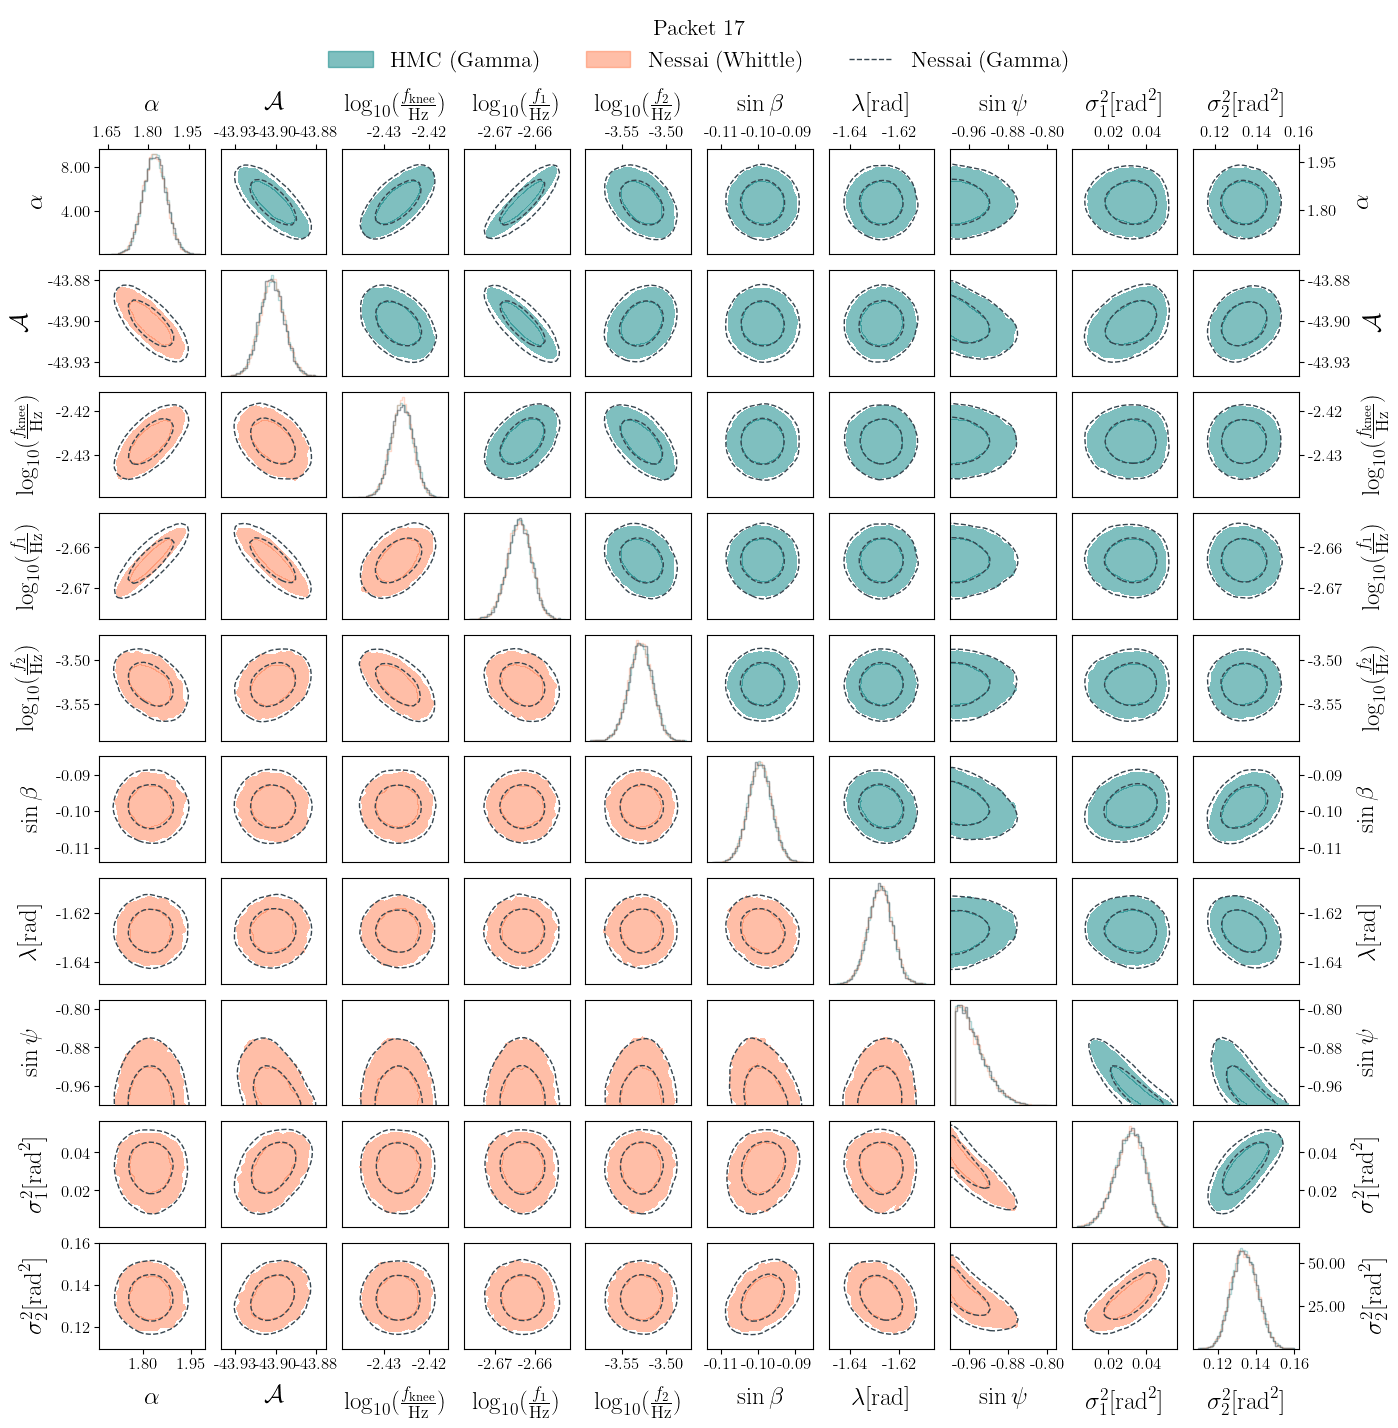

In [24]:
# Style parameters
alpha = 1
linewidth_corr = 1.0
ht = "step"

max_ticks = 3  # Increased from 2 to reduce overlap
decimal_digits = 2

# Sampler-specific line styles
line_styles = {
    "hmc_gamma": "solid",
    "nessai_whittle": "solid",
    "nessai_gamma": "dashed",
}

# Distinguishable colors
colors = {
    "hmc_gamma": "#008080",
    "nessai_whittle": "coral",
    "nessai_gamma": "#36454F",
}

# Select datasets
upper_samples = [("hmc_gamma", "hmc", "gamma"), ("nessai_gamma", "nessai", "gamma")]
lower_samples = [
    ("nessai_whittle", "nessai", "whittle"),
    ("nessai_gamma", "nessai", "gamma"),
]

ndim = sample_sets["hmc_gamma"].shape[1]


def plot_contour_with_fill(ax, x, y, name, levels=[0.6827, 0.9545]):
    """Plot 2D contours with optional fill"""
    # Create 2D histogram for contour plotting
    H, xedges, yedges = np.histogram2d(x, y, bins=50, density=True)
    X, Y = np.meshgrid((xedges[1:] + xedges[:-1]) / 2, (yedges[1:] + yedges[:-1]) / 2)

    # Smooth the histogram using gaussian filter
    from scipy import ndimage

    H = ndimage.gaussian_filter(H.T, sigma=1.0)

    # Calculate contour levels
    sorted_H = np.sort(H.flatten())[::-1]
    cum_H = np.cumsum(sorted_H)
    cum_H = cum_H / cum_H[-1]

    level_68 = sorted_H[np.argmax(cum_H >= 0.6827)]
    level_95 = sorted_H[np.argmax(cum_H >= 0.9545)]

    # Plot filled contours if not nessai_gamma
    if name != "nessai_gamma":
        ax.contourf(
            X,
            Y,
            H,
            levels=[level_95, level_68, H.max()],
            colors=[colors[name]],
            alpha=0.5,
        )

    else:
        contour_kwargs = {
            "alpha": alpha,
            "linestyles": line_styles[name],
            "linewidths": linewidth_corr,
            "colors": colors[name],
        }
        corner.hist2d(
            x,
            y,
            ax=ax,
            plot_datapoints=False,
            plot_contours=True,
            plot_density=False,
            no_fill_contours=True,
            fill_contours=False,
            smooth=True,
            levels=[0.6827, 0.9545],
            contour_kwargs={
                **contour_kwargs,
            },
            hist_kwargs={**hist_kwargs},
        )


# Create figure
fig, axes = plt.subplots(ndim, ndim, figsize=(1.5 * ndim, 1.5 * ndim))

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]

        # Histogram kwargs
        hist_kwargs = {
            "density": True,
            "histtype": ht,
            "linewidth": 1.0,
            "alpha": alpha,
        }

        # Upper triangle
        if i < j:
            for name, sampler, likelihood in upper_samples:
                plot_contour_with_fill(
                    ax, sample_sets[name][:, j], sample_sets[name][:, i], name
                )
        # Lower triangle
        elif i > j:
            for name, sampler, likelihood in lower_samples:
                plot_contour_with_fill(
                    ax, sample_sets[name][:, j], sample_sets[name][:, i], name
                )
        # Diagonal - stepfilled histograms with gray fill and colored edges
        else:
            for name, sampler, likelihood in upper_samples + lower_samples:
                # Stepfilled histogram with gray fill and colored edge
                ax.hist(
                    sample_sets[name][:, i],
                    bins=40,
                    density=True,
                    histtype="step",
                    linewidth=1.0,
                    facecolor="lightgray",
                    edgecolor=colors[name],
                    alpha=0.3,
                )

        # Set number of ticks and decimal digits for all subplots to prevent overlap
        ax.xaxis.set_major_locator(mticker.MaxNLocator(nbins=max_ticks, prune="both"))
        ax.yaxis.set_major_locator(mticker.MaxNLocator(nbins=max_ticks, prune="both"))
        ax.xaxis.set_major_formatter(mticker.FormatStrFormatter(f"%.{decimal_digits}f"))
        ax.yaxis.set_major_formatter(mticker.FormatStrFormatter(f"%.{decimal_digits}f"))

        # Set labels on outer edges
        if i == ndim - 1:  # bottom row
            ax.set_xlabel(label_plot[j])
            ax.xaxis.set_label_position("bottom")
            ax.xaxis.tick_bottom()
        elif i == 0:  # top row
            ax.set_xlabel(label_plot[j])
            ax.xaxis.set_label_position("top")
            ax.xaxis.tick_top()
        else:
            # Hide x-axis labels and ticks for inner rows
            ax.set_xticklabels([])
            ax.tick_params(axis="x", which="both", bottom=False, top=False)

        if j == 0:  # left column
            ax.set_ylabel(label_plot[i])
            ax.yaxis.set_label_position("left")
            ax.yaxis.tick_left()
        elif j == ndim - 1:  # right column
            ax.set_ylabel(label_plot[i])
            ax.yaxis.set_label_position("right")
            ax.yaxis.tick_right()
        else:
            # Hide y-axis labels and ticks for inner columns
            ax.set_yticklabels([])
            ax.tick_params(axis="y", which="both", left=False, right=False)

        # Additional tick formatting to prevent overlap
        ax.tick_params(axis="both", which="major", labelsize=12, pad=3)
        # Pad axes labels
        ax.xaxis.labelpad = 10
        ax.yaxis.labelpad = 10

# plt.tight_layout()

# Reduce spacing further with more generous spacing to prevent tick overlap
plt.subplots_adjust(
    left=0.10,  # increased from 0.08
    right=0.90,  # decreased from 0.92
    bottom=0.10,  # increased from 0.08
    top=0.90,  # decreased from 0.92
    wspace=0.15,  # increased from 0.1
    hspace=0.15,  # increased from 0.1
)

legend = [
    matplotlib.patches.Patch(color="#008080", label="HMC (Gamma)", alpha=0.5),
    matplotlib.patches.Patch(color="coral", label="Nessai (Whittle)", alpha=0.5),
    matplotlib.lines.Line2D(
        [0], [0], color="#36454F", lw=1, linestyle="--", label="Nessai (Gamma)"
    ),
]
fig.legend(
    handles=legend,
    loc="upper center",
    fontsize=16,
    ncol=3,
    frameon=False,
    title="Packet 17",
    title_fontsize="16",
)

# Save figure
fig.savefig("../plots/FigureA1.pdf", dpi=300, bbox_inches="tight")